In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras import backend as K
from keras.layers import LeakyReLU

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
#min_max_scaler = MinMaxScaler()

endpoint = 'https://min-api.cryptocompare.com/data/histoday'
#limit is num days of data to retrieve 
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1200')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
#hist.head()
hist.tail()

Using TensorFlow backend.


,close,high,low,open,volumefrom,volumeto
time,,,,,,
2020-02-19,9602.43,10300.04,9340.17,10182.60,47506.68,4.731003e+08
2020-02-20,9608.80,9698.59,9402.81,9602.43,36843.12,3.529494e+08
2020-02-21,9697.86,9766.16,9582.07,9608.80,30286.18,2.935462e+08
2020-02-22,9671.46,9720.21,9577.84,9697.86,12206.36,1.181715e+08
2020-02-23,9892.14,10011.40,9669.88,9671.46,18774.58,1.855404e+08


choose which feature to predict...here "closing price"

In [0]:
target_col = 'close'

use last test_size% of data for testing

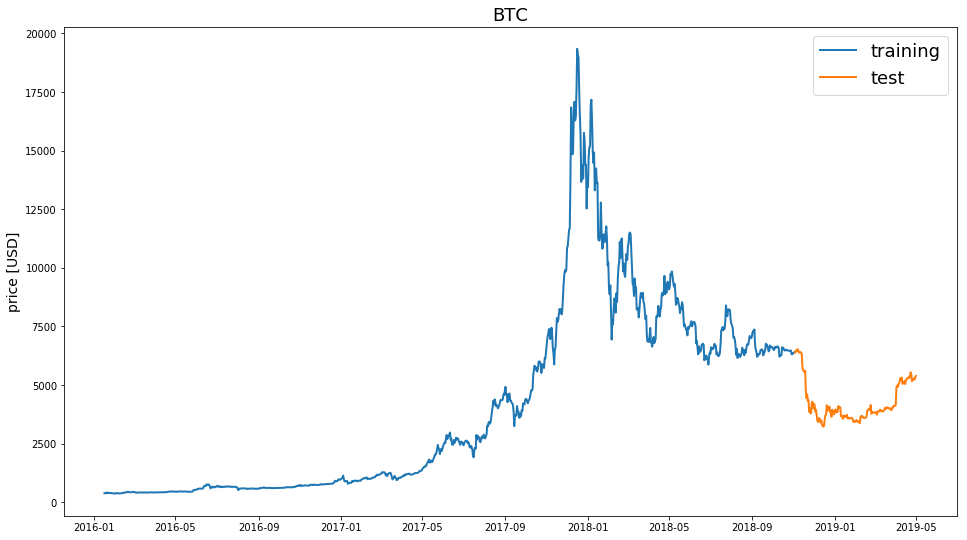

In [0]:
def train_test_split(df, test_size=0.15):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
def line_plot(line1, line2, label1=None, label2=None, title=''):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=2)
    ax.plot(line2, label=label2, linewidth=2)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)
train, test = train_test_split(hist, test_size=0.15)
line_plot(train.close, test.close, 'training', 'test', 'BTC')

For training the LSTM, the data was split into windows of 4 days (this number is somewhat arbitary) and within each window I normalised the data to zero base, i.e. the first entry of each window is 0 and all other values represent the change with respect to the first value. Hence, I am predicting price changes, rather than absolute price. 

Choose the value of window you'd like to use...how to "chunk" the time series. Change the two method params in extract_window_data and prepare_data

In [0]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with
        respect to first entry.
    """
    return df / df.iloc[0] - 1
def extract_window_data(df, window=4, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of
        length `window`.
    """
    window_data = []
    for idx in range(len(df) - window):
        tmp = df[idx: (idx + window)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(df, window=4, zero_base=True, test_size=0.15):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window, zero_base)
    X_test = extract_window_data(test_data, window, zero_base)
    
    # extract targets
    y_train = train_data.close[window:].values
    y_test = test_data.close[window:].values
    if zero_base:
        y_train = y_train / train_data.close[:-window].values - 1
        y_test = y_test / test_data.close[:-window].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test
train, test, X_train, X_test, y_train, y_test = prepare_data(hist)

In [0]:
def build_lstm_model(input_data, output_size, neurons=128,
                     activ_func='tanh', dropout=0.5,
                     loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(
              input_data.shape[1], input_data.shape[2])))
    model.add(LSTM(64))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    #model.add(LeakyReLU(alpha=.1))
    model.compile(loss=loss, optimizer=optimizer)
    return model
model = build_lstm_model(X_train, output_size=1)
history = model.fit(X_train, y_train, epochs=6, batch_size=12)

Epoch 1/6
1017/1017 [==============================] - 15s 15ms/step - loss: 0.0056
Epoch 2/6
1017/1017 [==============================] - 9s 8ms/step - loss: 0.0045
Epoch 3/6
1017/1017 [==============================] - 9s 8ms/step - loss: 0.0041
Epoch 4/6
1017/1017 [==============================] - 9s 8ms/step - loss: 0.0038
Epoch 5/6
1017/1017 [==============================] - 9s 8ms/step - loss: 0.0039
Epoch 6/6
1017/1017 [==============================] - 9s 8ms/step - loss: 0.0040


In [0]:
window=4

targets = test[target_col][window:]

preds = model.predict(X_test).squeeze()
preds2 = model.predict(X_train).squeeze()

print(r2_score(preds2, y_train))
print(r2_score(preds, y_test))

# convert change predictions back to actual price
preds = test.close.values[:-window] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

n = 180
line_plot(targets[-n:], preds[-n:], 'actual', 'prediction')

NameError: ignored